### Learning the CDF function of table attribute values via Isotonic Regression

In [17]:
import numpy as np
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt


In [5]:
# Initial data points and their CDF estimates
initial_data = np.array([1.0, 2.0, 3.0])
initial_cdf_values = np.array([0.1, 0.4, 0.7])

# Fit the initial isotonic regression model
cdf_model = IsotonicRegression(increasing=True)
cdf_model.fit(initial_data, initial_cdf_values)

# Function to update the model incrementally
def update_model(cdf_model, new_point, new_cdf_value, predicate_type):
    if predicate_type == "<=":
        # Append the new data point and its CDF value
        updated_data = np.append(cdf_model.X_thresholds_, new_point)
        updated_cdf_values = np.append(cdf_model.y_thresholds_, new_cdf_value)
    elif predicate_type == ">":
        # Convert the "greater than" predicate to a CDF value
        new_cdf_value = 1 - new_cdf_value
        updated_data = np.append(cdf_model.X_thresholds_, new_point)
        updated_cdf_values = np.append(cdf_model.y_thresholds_, new_cdf_value)
    else:
        raise ValueError("Predicate type must be '<=' or '>'")

    # Refit the model with the updated data
    cdf_model.fit(updated_data, updated_cdf_values)


# Function to predict CDF values, with handling for out-of-bounds
def predict_cdf_with_bounds(cdf_model, points):
    predictions = []
    min_data = min(cdf_model.X_thresholds_)
    max_data = max(cdf_model.X_thresholds_)
    
    for point in points:
        if point < min_data:
            predictions.append(0.0)  # CDF is 0 below the minimum
        elif point > max_data:
            predictions.append(1.0)  # CDF is 1 above the maximum
        else:
            predictions.append(cdf_model.predict(np.array([point]))[0])
    
    return np.array(predictions)


In [6]:

# New observations (range predicates and their selectivity)
new_observations = [
    (4.0, 0.8, "<="),  # (new_point, new_cdf_value, predicate_type)
    (5.0, 0.1, ">")
]

# Update the model with each new observation
for new_point, new_cdf_value, predicate_type in new_observations:
    update_model(cdf_model, new_point, new_cdf_value, predicate_type)

# Predict CDF values for a new range
new_range = np.array([2.5, 4.5, 5.5])
predicted_cdf = predict_cdf_with_bounds(cdf_model, new_range)

print("Predicted CDF values:", predicted_cdf)

Predicted CDF values: [0.55 0.85 1.  ]


### Simple example: Learning a uniform distribution

In [10]:
def uniform_pdf(x, a, b):
    if a <= x <= b:
        return 1 / (b - a)
    else:
        return 0.0
    

def uniform_cdf(x, a, b, noise_level=0.0):
    # Calculate the exact CDF value
    if x < a:
        cdf_value = 0.0
    elif x > b:
        cdf_value = 1.0
    else:
        cdf_value = (x - a) / (b - a)
    
    # Add noise if specified
    if noise_level > 0.0:
        noise = np.random.uniform(-noise_level, noise_level)
        cdf_value = np.clip(cdf_value + noise, 0.0, 1.0)
    
    return cdf_value

In [15]:
# Define the domain [a, b]
a, b = 2.0, 5.0

# Generate test values over the domain
x_values = np.linspace(a - 1, b + 1, 100)

# Generate exact CDF values
exact_cdf_values = [uniform_cdf(x, a, b) for x in x_values]

# Simulate noisy CDF data
x_data = np.linspace(a, b, 10)
pdf_values = [uniform_pdf(x, a, b) for x in x_data]
cdf_values = [uniform_cdf(x, a, b) for x in x_data]
noisy_cdf_data = [uniform_cdf(x, a, b, noise_level=0.05) for x in x_data]
noisy_cdf_data = np.clip(noisy_cdf_data, 0, 1)  # Ensure values are between 0 and 1


print("PDF values:", pdf_values)
print("Exact CDF values:", cdf_values)
print("Noisy CDF values:", noisy_cdf_data)

PDF values: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Exact CDF values: [0.0, 0.11111111111111116, 0.22222222222222218, 0.3333333333333333, 0.44444444444444436, 0.5555555555555555, 0.6666666666666666, 0.7777777777777777, 0.8888888888888887, 1.0]
Noisy CDF values: [0.0139921  0.07544644 0.26668911 0.33551817 0.43591064 0.53201112
 0.69409004 0.77339281 0.89573228 0.95187898]


In [16]:
# Fit isotonic regression model on the noisy CDF data
iso_reg = IsotonicRegression(increasing=True)
iso_reg.fit(x_data, noisy_cdf_data)

IsotonicRegression()

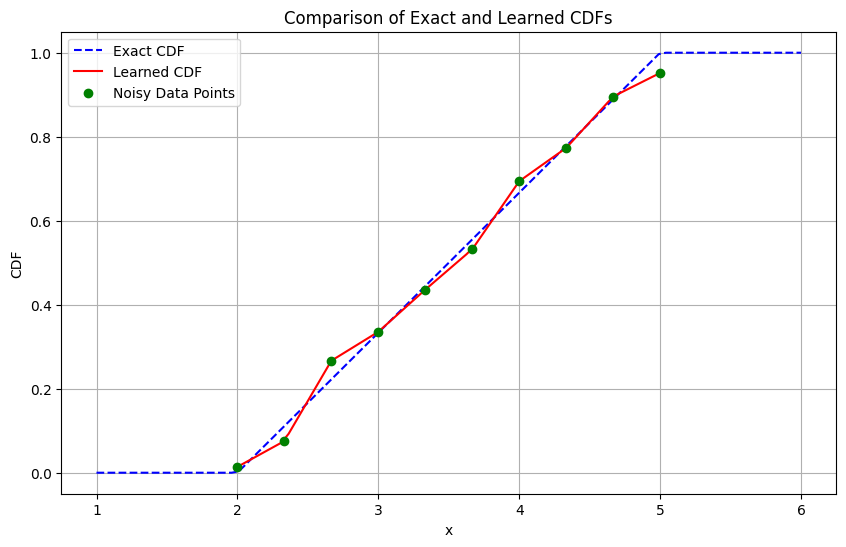

In [18]:
# Predict CDF values using the learned model
learned_cdf_values = iso_reg.predict(x_values)

# Plot the exact and learned CDFs
plt.figure(figsize=(10, 6))
plt.plot(x_values, exact_cdf_values, label='Exact CDF', color='blue', linestyle='--')
plt.plot(x_values, learned_cdf_values, label='Learned CDF', color='red')
plt.scatter(np.linspace(a, b, 10), noisy_cdf_data, color='green', label='Noisy Data Points', zorder=5)
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Comparison of Exact and Learned CDFs')
plt.legend()
plt.grid(True)
plt.show()